In [9]:
symbol = 'BTCUSDT'
timeframes = ['1h', '4h','1d']
base_tf = '1h'

In [10]:
def get_data(symbol, tf):
    import pandas as pd
    df = pd.read_csv(f'./data/{symbol}_{tf}.csv')
    df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df.set_index('Date',inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume','Taker_buy_base']]
    df.index = pd.to_datetime(df.index)
    return df

In [11]:
import pandas as pd
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import AverageTrueRange
from ta.trend import ADXIndicator

def add_indicators(df):
    df.columns = df.columns.str.capitalize()
    df['Delta_volume'] = df['Taker_buy_base'] - (df['Volume'] - df['Taker_buy_base'])
    df['cvd'] = df['Delta_volume'].cumsum()
    df['cvd_rolling'] = df['cvd'].rolling(12).mean()
    df['adx'] = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close']).adx()
    df['obv'] = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()
    df['atr'] = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()
    df['cvd_momentum'] = df['cvd_rolling'] - df['cvd_rolling'].shift(5)

    df['ret_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['ret_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['ret_15'] = df['Close'] / df['Close'].shift(15) - 1

    df['vol_compression'] = df['atr'] / df['Close'].rolling(14).std()

    df.dropna(inplace=True)  
    # df['lower_wick'] = df[['Close', 'Open']].min(axis=1) -  df['Low']
    # df['upper_wick'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    # df['body_size'] = df['Close'] - df['Open']
    df.drop(columns=['High', 'Open', 'Low', 'Volume', 'Taker_buy_base','cvd','Delta_volume'], inplace=True)
    
    return df

In [12]:
df = get_data(symbol, base_tf)

In [13]:
df

,Open,High,Low,Close,Volume,Taker_buy_base
Date,,,,,,
2024-03-01 00:00:00,61130.99,61749.00,61126.00,61501.11,1867.79902,1026.79855
2024-03-01 01:00:00,61501.10,61566.95,61125.40,61214.35,1552.25486,724.04590
2024-03-01 02:00:00,61214.35,61214.36,60781.25,60980.00,1600.91093,742.72814
2024-03-01 03:00:00,60980.00,61222.22,60777.00,61105.91,1324.61160,714.24953
2024-03-01 04:00:00,61105.92,61524.09,61061.11,61524.09,1067.62569,630.30296
...,...,...,...,...,...,...
2025-05-31 20:00:00,104698.03,104807.94,104533.54,104781.83,150.05341,70.05110
2025-05-31 21:00:00,104781.84,104884.16,104645.73,104863.16,317.26216,153.91046
2025-05-31 22:00:00,104863.16,104900.00,104603.08,104625.80,228.10691,100.12835


In [14]:
dfs = {}
for tf in timeframes:
    df = get_data(symbol,tf)
    df = add_indicators(df)
    dfs[tf] = df

In [18]:
dfs[base_tf] =dfs[base_tf][2000:]

In [19]:
dfs['1h'].shape, dfs['4h'].shape, dfs['1d'].shape

((8953, 10), (2151, 10), (442, 10))

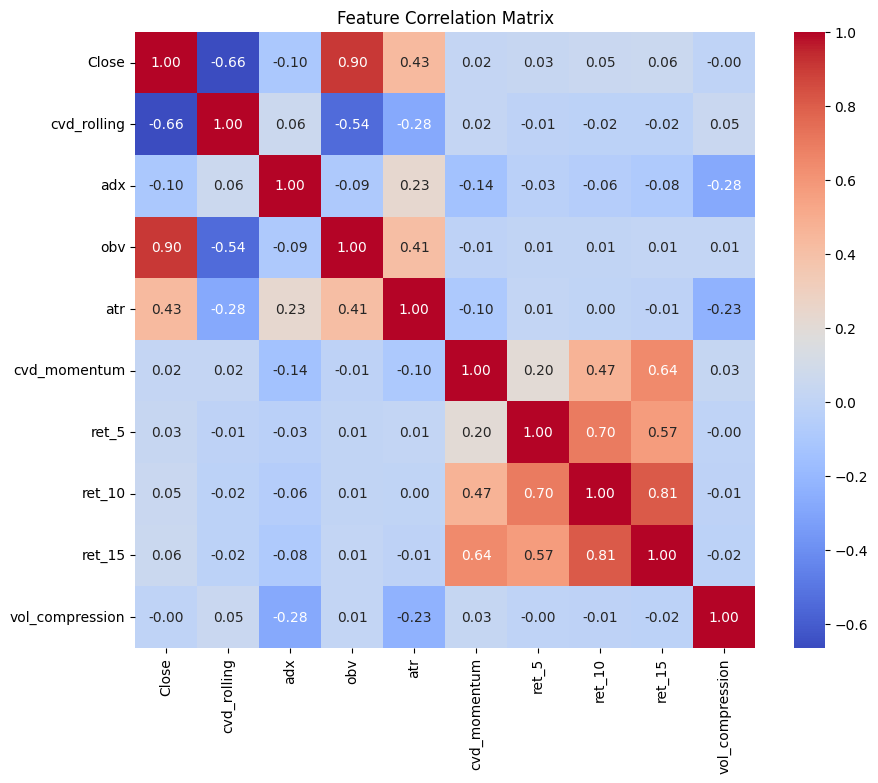

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe with OHLCV + indicators
correlation_matrix = dfs[base_tf].corr()
# Visualize
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [23]:
def add_target_column(df, lookahead=10):
    target = []

    for i in range(len(df)):
        start_price = df['Close'].iloc[i]
        valid_bars = df.iloc[i+1:i+1+lookahead]
        max_percent = -1

        for j in range(len(valid_bars)):
            curr_price = valid_bars['Close'].iloc[j]
            max_percent =  max(max_percent,(curr_price - start_price) / start_price)
        
        target.append(max_percent)

    df_copy = df.copy()
    df_copy['Target'] = target
    df_target = df_copy[['Target']]
    return df_target


In [25]:
df_target = add_target_column(dfs[base_tf],lookahead=10)

In [26]:
df_target

,Target
Date,
2024-05-24 00:00:00,0.001862
2024-05-24 01:00:00,0.003489
2024-05-24 02:00:00,-0.001273
2024-05-24 03:00:00,-0.002704
2024-05-24 04:00:00,0.002382
...,...
2025-05-31 20:00:00,0.000776
2025-05-31 21:00:00,-0.002264
2025-05-31 22:00:00,-0.000324


In [27]:
dfs[base_tf] = dfs[base_tf][:-10]

In [28]:
from sklearn.preprocessing import StandardScaler

def standerd_scale(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
    return df_scaled, scaler

In [29]:
dfs_scaled = {}
scalars = {}
for tf in timeframes:
    df_scaled, scalar = standerd_scale(dfs[tf])
    dfs_scaled[tf] = df_scaled
    scalars[tf] = scalar

In [30]:
import pickle
for tf in timeframes:
    name = f'./output/{symbol}_{tf}.pkl'
    with open(name, 'wb') as f:
        pickle.dump(scalars[tf], f)

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class MultiTFDataset(Dataset):
    def __init__(self, dfs_scaled, targets, seq_len=48, augment=True):
        self.dfs_scaled = dfs_scaled
        self.targets = targets
        self.seq_len = seq_len
        self.augment = augment

        self.valid_indices = self.dfs_scaled[base_tf].index[self.seq_len:]

    def get_end_indices(self, t):
        t_4h = t.floor('4h') - pd.Timedelta(hours=4)
        t_1d = t.floor('D') - pd.Timedelta(days=1)
        return t_4h, t_1d

    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        end_1h = self.valid_indices[idx]
        end_4h, end_1d = self.get_end_indices(end_1h)

        seq_1h = self.dfs_scaled['1h'].loc[:end_1h].iloc[-self.seq_len:]
        seq_4h = self.dfs_scaled['4h'].loc[:end_4h].iloc[-self.seq_len:]
        seq_1d = self.dfs_scaled['1d'].loc[:end_1d].iloc[-self.seq_len:]

        x = torch.stack([
            torch.tensor(seq_1h.values, dtype=torch.float32),
            torch.tensor(seq_4h.values, dtype=torch.float32),
            torch.tensor(seq_1d.values, dtype=torch.float32)
        ], dim=0)  # shape: [3, T, F]

        if self.augment:
            x = self.apply_augmentation(x)

        y = torch.tensor(self.targets.loc[end_1h].item(), dtype=torch.long)
        return x, y , str(end_1h) 

    def apply_augmentation(self, x):
        # x shape: [3, T, F]
        noise_level = 0.01
        jitter = noise_level * torch.randn_like(x)
        return x + jitter

In [14]:
r = MultiTFDataset(dfs_scaled=dfs_scaled,targets = df_target)

In [15]:
t = r.__getitem__(-1)

In [16]:
t[2]

'2025-05-31 00:00:00'

In [17]:
for i in range(r.__len__()):
    t = r.__getitem__(i)
    
    if t[0].shape != torch.Size([3, 48, 10]):
        print(i, t[0].shape)

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Compute class weights for binary classification
classes = np.unique(df_target['Target'])  # should be [0, 1]
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_target['Target'])

# Convert to tensor
# Important: BCEWithLogitsLoss accepts pos_weight, which applies only to the positive class (label 1)
# So we extract the ratio as pos_weight = weight_for_1 / weight_for_0

pos_weight = class_weights[1] / class_weights[0]
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

# Use BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNMultiTF(nn.Module):
    def __init__(self,no_of_tf = 3, num_classes=3):
        super(CNNMultiTF, self).__init__()

        # Input shape: [batch, channels=3, T, F]
        self.conv1 = nn.Conv2d(in_channels=no_of_tf, out_channels=16, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(p=0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global avg pooling
        self.fc1 = nn.Linear(32, 16)  # Output logits for 3 classes
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # [batch, 16, T, F]
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))  # [batch, 32, T, F]
        x = self.pool(x)                      # [batch, 32, 1, 1]
        x = x.view(x.size(0), -1)             # [batch, 32]
        x = F.relu(self.fc1(x))               # [batch, 16]
        x = self.fc2(x)                       # [batch, 1]
        return x.squeeze(dim=1)               # [batch]


In [20]:
from torch.utils.data import DataLoader

dfs_train = dfs_scaled.copy()
dfs_train[base_tf] = dfs_train[base_tf][:-4000]
train_dataset = MultiTFDataset(dfs_scaled=dfs_train, targets=df_target, seq_len=48, augment=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
def train(no_of_epoch=50):
    model = CNNMultiTF()  # make sure it outputs [B] or [B, 1]
    model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    max_accuracy = 0

    for epoch in range(no_of_epoch):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_x, batch_y, _ in train_loader:
            batch_x = batch_x.to(device)                  # shape: [B, 3, T, F]
            batch_y = batch_y.to(device).float()          # shape: [B], dtype: float

            optimizer.zero_grad()

            outputs = model(batch_x).squeeze()            # shape: [B], raw logits
            loss = criterion(torch.sigmoid(outputs), batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)

            # Accuracy
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == batch_y.bool()).sum().item()
            total += batch_y.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss / total:.4f}, Acc: {accuracy:.4f}")

        if accuracy >= max_accuracy:
            max_accuracy = accuracy
            torch.save(model, f'./models/Acc_{accuracy:.3f}.pth')
        
    return model


In [23]:
model = train()

Epoch 1, Loss: 0.5810, Acc: 0.7040
Epoch 2, Loss: 0.5463, Acc: 0.7226
Epoch 3, Loss: 0.5239, Acc: 0.7357
Epoch 4, Loss: 0.5081, Acc: 0.7461
Epoch 5, Loss: 0.4836, Acc: 0.7566
Epoch 6, Loss: 0.4657, Acc: 0.7737
Epoch 7, Loss: 0.4532, Acc: 0.7797
Epoch 8, Loss: 0.4380, Acc: 0.7929
Epoch 9, Loss: 0.4218, Acc: 0.8014
Epoch 10, Loss: 0.4108, Acc: 0.8099
Epoch 11, Loss: 0.4004, Acc: 0.8152
Epoch 12, Loss: 0.3823, Acc: 0.8313
Epoch 13, Loss: 0.3713, Acc: 0.8399
Epoch 14, Loss: 0.3680, Acc: 0.8367
Epoch 15, Loss: 0.3589, Acc: 0.8474
Epoch 16, Loss: 0.3480, Acc: 0.8537
Epoch 17, Loss: 0.3425, Acc: 0.8535
Epoch 18, Loss: 0.3340, Acc: 0.8603
Epoch 19, Loss: 0.3315, Acc: 0.8619
Epoch 20, Loss: 0.3228, Acc: 0.8638
Epoch 21, Loss: 0.3110, Acc: 0.8762
Epoch 22, Loss: 0.3151, Acc: 0.8663
Epoch 23, Loss: 0.3050, Acc: 0.8762
Epoch 24, Loss: 0.3059, Acc: 0.8742
Epoch 25, Loss: 0.3030, Acc: 0.8759
Epoch 26, Loss: 0.2947, Acc: 0.8787
Epoch 27, Loss: 0.2893, Acc: 0.8820
Epoch 28, Loss: 0.2860, Acc: 0.8862
E

In [35]:
import torch
model_test = torch.load('./models/Acc_0.905.pth', weights_only=False)

In [46]:
from torch.utils.data import DataLoader
dfs_test = dfs_scaled.copy()
dfs_test[base_tf] = dfs_test[base_tf][-4000:]
test_dataset = MultiTFDataset(dfs_scaled=dfs_test, targets=df_target, seq_len=48, augment=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [47]:
def test(model):
    model.eval()
    all_test_predictions = []
    all_test_labels = []
    all_indices = []

    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y, batch_idx in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            predicted = (torch.sigmoid(outputs) > 0.5).long()

            all_test_predictions.extend(predicted.cpu().tolist())
            all_test_labels.extend(batch_y.cpu().tolist())
            all_indices.extend(batch_idx)  # Save indices

            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    return all_test_predictions, all_test_labels, all_indices

In [48]:
test_preds, test_labels , test_idx = test(model_test)

Test Accuracy: 0.7614


In [49]:
import pandas as pd

results = pd.DataFrame({
    'Date': test_idx,
    'True_label': test_labels,
    'Prediction': test_preds
})
results['Date'] = pd.to_datetime(results['Date'])
results.to_csv("./intermediate/test_results.csv", index=False)

In [50]:
pred_cnt = results['Prediction'].value_counts()
true_labels = results['True_label'].value_counts()

In [51]:
pred_cnt,true_labels

(Prediction
 0    3630
 1     322
 Name: count, dtype: int64,
 True_label
 0    2829
 1    1123
 Name: count, dtype: int64)

In [56]:
tp_class_0 = ((results['True_label'] == 0) & (results['Prediction'] == 0)).sum()
tp_class_1 = ((results['True_label'] == 1) & (results['Prediction'] == 1)).sum()
# tp_class_2 = ((results['True_label'] == 2) & (results['Prediction'] == 2)).sum()/ true_labels[2]
fp_class_1 = ((results['True_label'] == 1) & (results['Prediction'] == 0)).sum()
fp_class_0 = ((results['True_label'] == 0) & (results['Prediction'] == 1)).sum()

# num_of_opps_class = int(((results['True_label'] == 1) & (results['Prediction'] == 2)).sum()) + int(((results['True_label'] == 2) & (results['Prediction'] == 1)).sum())

In [57]:
tp_class_0, tp_class_1

(np.int64(2758), np.int64(251))

In [58]:
fp_class_1, fp_class_0

(np.int64(872), np.int64(71))